In [1]:
# default_exp fitting

# Fitting by Likelihood
To fit a model to some dataset, we select a cost function that scales against the likelihood that the model with a specified parameter configuration could have generated the specified dataset. We'll demonstrate the process of designing a log-likelihood cost function and applying it to fit model parameters here.

In [2]:
# export
# hide

import numpy as np
from numba import njit, prange

@njit(fastmath=True, nogil=True, parallel=True)
def murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters):

    result = 0.0
    for i in prange(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        likelihood = np.ones((len(trials), item_count))

        model = model_class(item_count, item_count, parameters)
        model.experience(model.items)

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recall of indexed item 
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities()[recall] + 10e-7
                
                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        
        result -= np.sum(np.log(likelihood))

    return result

In [3]:
# export
# hide

from numba.typed import Dict
from numba.core import types

def murdock_objective_function(data_to_fit, item_counts, model_class, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for search over specified free/fixed parameters.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters)

    return objective_function

## Single-Subject Demo
Using these functions, we'll search for and visualize a parameter fit of the CMR model to a slice of data sampled from the classic Murdock (1962) study demonstrating the serial position curve, a pattern where early and later presented items tend to be recalled more often than middle items in a list-learning experiment. The data associated with the study is located at `data/MurdData_clean.mat`.

In [4]:
from compmemlearn.datasets import prepare_murdock1962_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../data/MurdData_clean.mat', 2)

murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


### Testing the Likelihood Function
Our `cmr_murd_likelihood` function accepts a numba `List` variable containing our data and a parameter configuration for CMR and returns the summed log-likelihood of the data given the model and its parameters. Let's test it out on the first subject of our dataset and time the function, too. Fitting functions execute a cost function many times over many candidate parameter configurations, so it's important that our cost function be snappy.

In [5]:
from numba.typed import List
from compmemlearn.datasets import prepare_murdock1962_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../data/MurdData_clean.mat', 2)
murd_events0.head()


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


In [6]:
from compmemlearn.models import Classic_CMR

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate',
    'mfc_familiarity_scale',
    'mcf_familiarity_scale',
    'drift_familiarity_scale']

fit_values = [8.36412380e-01, 1.37438014e-01, 9.14231622e-01, 1.03548867e-01,
 1.00000000e+00, 2.70091435e-01, 3.89549514e+00, 6.04259249e-01,
 2.04970025e-02, 1.20035161e-01, 1.78302334e+00, 9.96231007e-01,
 0.0, 0.0, 0.0]

cmr_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(fit_values)):
    cmr_parameters[free_parameters[i]] = fit_values[i]
cmr_parameters['sampling_rule'] = 0

@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

murdock_data_likelihood(List([murd_trials0, murd_trials1, murd_trials2]), List([murd_length0,murd_length1, murd_length2]), init_cmr, cmr_parameters)


88662.15139967931

In [7]:
%%timeit
murdock_data_likelihood(List([murd_trials0, murd_trials1, murd_trials2]), List([murd_length0,murd_length1, murd_length2]), init_cmr, cmr_parameters)

62.1 ms ± 628 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


With the runtime of the cost function established, we'll now use it with scipy's `differential_evolution` function to find the best fit parameters for the model to the single subject we're examining.

In [8]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate')

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = murdock_objective_function(
    List([murd_trials0[:80]]), 
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 1949.01
differential_evolution step 2: f(x)= 1902.13
differential_evolution step 3: f(x)= 1902.13
differential_evolution step 4: f(x)= 1879.41
differential_evolution step 5: f(x)= 1758.42
differential_evolution step 6: f(x)= 1735.59
differential_evolution step 7: f(x)= 1528.09
differential_evolution step 8: f(x)= 1528.09
differential_evolution step 9: f(x)= 1528.09
differential_evolution step 10: f(x)= 1528.09
differential_evolution step 11: f(x)= 1523.32
differential_evolution step 12: f(x)= 1523.32
differential_evolution step 13: f(x)= 1492.73
differential_evolution step 14: f(x)= 1492.73
differential_evolution step 15: f(x)= 1492.73
differential_evolution step 16: f(x)= 1492.73
differential_evolution step 17: f(x)= 1492.73
differential_evolution step 18: f(x)= 1492.73
differential_evolution step 19: f(x)= 1492.73
differential_evolution step 20: f(x)= 1492.73
differential_evolution step 21: f(x)= 1492.73
differential_evolution step 22: f(x)= 1492.

```
     fun: 334.8777551424363
     jac: array([ 0.05269953,  0.02183924, -0.05717879, -0.03206537,  0.03207106,
        0.01166427,  0.006645  ,  0.        ,  0.15124897,  0.0152852 ,
       -0.07726157])
 message: 'Optimization terminated successfully.'
    nfev: 17823
     nit: 98
 success: True
       x: array([7.22947401e-02, 2.22044605e-16, 9.15228274e-01, 8.61426662e-01,
       4.97575652e-01, 4.51159821e-01, 8.45882130e-02, 7.05539075e+01,
       5.73578332e-03, 6.24906872e-01, 6.78579935e-02])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

### Visualizing Fit
Next we'll visualize the fit of the model and its parameters to the data. We'll do this by simulating a dataset using the models and our parameters found above and plotting its simulated benchmark recall phenomena (serial position curve, lag-CRP, and probability of first recall) against the actual data. A new helper function called `apply_and_concatenate` helps streamline the process of setting up tables for comparison of an analysis outcome between simulated and real data.

In [9]:
# export
import pandas as pd

def apply_and_concatenate(function, df1, df2, contrast_name='contrast', labels='AB'):
    """
    Concatenates the results of a function applied to two dataframes and creates a new column identifying the contrast.
    """
    return pd.concat([function(df1), function(df2)], keys=labels, names=[contrast_name]).reset_index()

Now let's create some simulated data with our model and fitted parameters.

In [10]:
from compmemlearn.datasets import simulate_data

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(result.x)):
    fitted_parameters[free_parameters[i]] = result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0


model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.loc[murd_events0['subject'] == 1]


#### Serial Position Curve

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from psifr import fr

%config InlineBackend.figure_formats = ['svg']


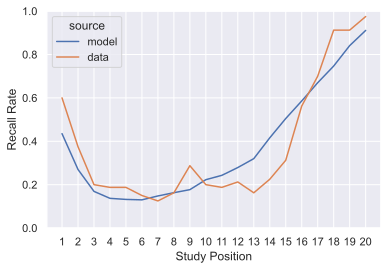

In [12]:
spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['model', 'data'])

sns.set(style='darkgrid')
g = sns.lineplot(data=spc, x='input', y='recall', hue='source', err_style='bars', ci=None)
plt.xlabel('Study Position')
plt.ylabel('Recall Rate')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
g.set(ylim=(0, 1))
plt.show()

#### Lag-CRP

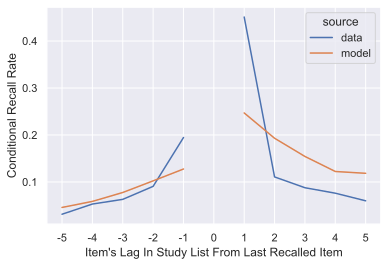

In [13]:
lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['model', 'data'])

max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'
sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', hue='source', ci=False, hue_order=['data', 'model'])
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', hue='source', ci=False, hue_order=['data', 'model'], legend=False)

plt.xlabel('Item\'s Lag In Study List From Last Recalled Item')
plt.ylabel('Conditional Recall Rate')
plt.xticks(np.arange(-5, 6, 1), np.arange(-5, 6, 1))

g.set(ylim=(0, .5))
plt.show()

#### Probability of First Recall

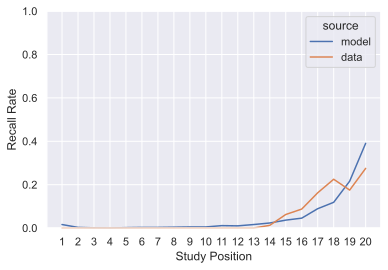

In [14]:
pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['model', 'data'])
pfr = pfr.query('output <= 1')

sns.set(style='darkgrid')
g = sns.lineplot(data=pfr, x='input', y='prob', hue='source', err_style='bars', ci=None)
plt.xlabel('Study Position')
plt.ylabel('Recall Rate')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
g.set(ylim=(0, 1))
plt.show()

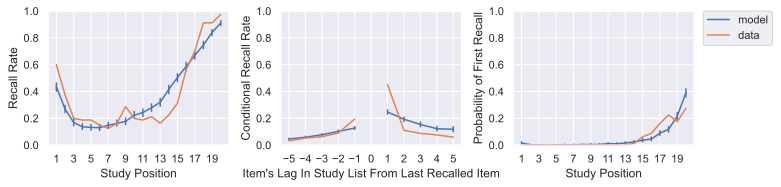

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(11, 11/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', err_style='bars', ax=axes[1], hue='source', legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', err_style='bars', ax=axes[1], hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', ax=axes[2], hue='source')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

#### Why aren't the fits better?
The model doesn't actually do a good job of capturing some of the quirks in the data -- namely the graded probability of first recall curve in that last plot. CMR predicts a much sharper curve than the actual data and its struggle to account for something different results in worse apparent fits to other benchmark recall phenomena visualized here too. At least, that's our best guess about what's behind the failure.